In [3]:
print("\nImports...")

import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import pickle
import os
import sys
sys.path.append( '/home/ebutz/ESL2024/code/utils' )
import play_with_complex as pwc


import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F


from nxontology.imports import from_file

# ------------- Paths ------------- #

# Iric
mapped_iric_path  = '/home/ebutz/ESL2024/data/full_iric/altailed_mapped_iric.pickle'
altails_dict_path = '/home/ebutz/ESL2024/data/full_iric/altail_iric_DICT.pickle'

# Model to train :
hidden_channels = 5
batch_size      = 4096
epochs          = 150
eval_period     = 2
lin_factor      = 1
xp_name = f'LinSim labels vs others on full dataset with 6*{hidden_channels} HC'

params_save_name = f"PARAMS_ComplEx_6_times_{hidden_channels}_HC_{epochs}_epochs_{batch_size}_BS_on_full_iric"
model_parameters_path = "/home/ebutz/ESL2024/data/mapping_datasets_and_model_for_genes_to_phenotypes_iric/"+params_save_name

# Ontology
ontology_path = "/home/ebutz/ESL2024/data/go-basic.json.gz"
check_dicts = False

# ------------- Cuda ------------- #

device = 'cpu'
print(f"Device: '{device}'")
print("Could reach GPU :", torch.Tensor([0,1]).to(device).is_cuda)


# ------------- Loading datas ------------- #

print("\nLoading iric...")
mapped_iric = pd.read_pickle(mapped_iric_path)
print(mapped_iric.head())
print('mapped_alt_tails type :', type(mapped_iric.iloc[0]['mapped_alt_tails']))

GO_to_map = mapped_iric.set_index('object')['mapped_object'].to_dict()
map_to_GO = {value: key for key, value in GO_to_map.items()}

if check_dicts:
    looks_ok: bool = True
    for i in tqdm(range(len(list(mapped_iric['object']))), desc = "Checking GO to MAP dict"):
        if GO_to_map[mapped_iric['object'][i]]!=mapped_iric['mapped_object'][i] :
            looks_ok = False
    print('GO - Mapping dicts looks ok :', looks_ok)

with open(altails_dict_path, 'rb') as handle:
    mapped_alt_tails = pickle.load(handle)
print("Alternative tails dict (first key-value pair):", list(mapped_alt_tails.items())[0])

# # ------------- Making datasets ------------- #

print("\nMaking datasets...")
# Edges index :
heads = list(mapped_iric['mapped_subject'])
tails = list(mapped_iric['mapped_object'])
edge_index = torch.tensor([heads,tails], dtype=torch.long)
# edges attributes :
edge_attributes = torch.tensor(mapped_iric['mapped_predicate'])


iric_pyg = Data(
                num_nodes = len(set(mapped_iric['object']).union(set(mapped_iric['subject']))),
                edge_index = edge_index,
                edge_attr = edge_attributes
                )

print(iric_pyg)

print("\nDataset looks valid :",iric_pyg.validate(raise_on_error=True))

transform = RandomLinkSplit(
                            num_val = 0.1,
                            num_test = 0.1,
                            is_undirected = False,
                            add_negative_train_samples = False,
                            )

train_set, val_set, test_set = transform(iric_pyg)
print('Dataset splits look valid (train, val, test):',train_set.validate(raise_on_error = True),
                                                      val_set.validate(raise_on_error   = True),
                                                      test_set.validate(raise_on_error  = True))

# ------------- Loading ontology ------------- #

print("\nLoading ontology...")
nxo = from_file(ontology_path)
nxo.freeze()

# ------------- Making global variables accessibles to pwc ------------- #

pwc.map_to_GO        = map_to_GO
pwc.nxo              = nxo
pwc.mapped_alt_tails = mapped_alt_tails
pwc.device           = device


# ------------- Init model ------------- #

LinSim_labels = pwc.ComplEx_with_LinSim_labels(
                                    num_nodes       = train_set.num_nodes,
                                    num_relations   = train_set.edge_index.size()[1],
                                    hidden_channels = hidden_channels,
                                    ).to(device)
# pwc.train_and_test_complex(model      = LinSim_labels,
    #                         train_data = train_set,
    #                         test_data  = test_set,
    #                         device     = device,
    #                         use_wandb  = False,
    #                         xp_name    = xp_name,
    #                         run_name   = 'LinSim_labels',
    #                         eval_period= eval_period,
    #                         epochs = epochs
    #                         )


Imports...
Device: 'cpu'
Could reach GPU : False

Loading iric...
      subject predicate      object  mapped_subject  mapped_predicate  \
0  GO:0000001      is_a  GO:0048311           49100                 0   
1  GO:0000001      is_a  GO:0048308           49100                 0   
2  GO:0000002      is_a  GO:0007005            9015                 0   
3  GO:0000003      is_a  GO:0008150             379                 0   
4  GO:0000006      is_a  GO:0005385           78507                 0   

   mapped_object mapped_alt_tails  
0          35069          [26571]  
1          26571          [35069]  
2          26957               []  
3          11514               []  
4          48466               []  
mapped_alt_tails type : <class 'numpy.ndarray'>
Alternative tails dict (first key-value pair): ((49100, 0), [26571, 35069])

Making datasets...
Data(edge_index=[2, 1452521], edge_attr=[1452521], num_nodes=82249)

Dataset looks valid : True
Dataset splits look valid (train, val,

In [10]:
loader = LinSim_labels.loader(
    head_index = train_set.edge_index[0],
    tail_index = train_set.edge_index[1],
    rel_type = train_set.edge_attr,
    batch_size=batch_size,
    shuffle=False,)

batchy = next(iter(loader))
print(batchy)

(tensor([ 3542, 57880, 58774,  ..., 41457, 80722, 29588]), tensor([3, 3, 3,  ..., 3, 3, 3]), tensor([65972, 11408, 13688,  ..., 40224, 39805,  5668]))


In [19]:
bls = pwc.best_lin_sims_for_batch(*batchy)
print('non-zero :',torch.count_nonzero(bls))
print(bls.size())


non-zero : tensor(538)
torch.Size([4096])


(array([3.558e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 3.000e+00,
        1.000e+00, 4.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 8.000e+00, 4.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        8.000e+00, 3.000e+00, 7.000e+00, 2.000e+00, 1.200e+01, 4.000e+00,
        1.000e+01, 4.000e+00, 1.000e+01, 7.000e+00, 2.000e+00, 4.000e+00,
        3.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 5.000e+00,
        3.000e+00, 3.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 1.200e+01,
        7.000e+00, 6.000e+00, 7.000e+00, 3.000e+00, 4.000e+00, 4.000e+00,
        7.000e+00, 4.000e+00, 5.000e+00, 7.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00, 1.300e+01, 9.000e+00, 4.000e+00, 1.500e+01, 1.000e+00,
        6.000e+00, 1.400e+01, 7.000e+0

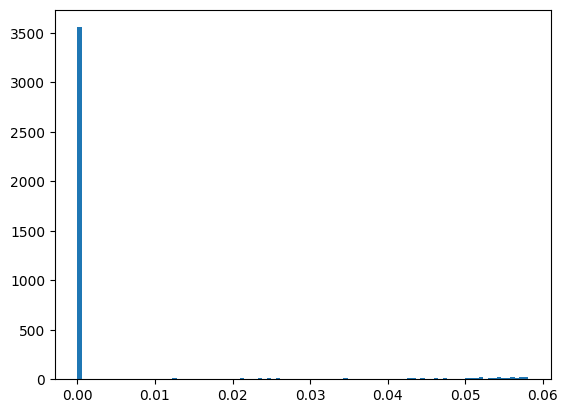

In [28]:
from torch.nn.functional import normalize as norm
nbls = norm(bls, dim = 0)
import matplotlib.pyplot as plt
plt.hist(x = nbls, bins = 100)


(array([3.558e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 3.000e+00,
        1.000e+00, 4.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 8.000e+00, 4.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        8.000e+00, 3.000e+00, 7.000e+00, 2.000e+00, 1.200e+01, 4.000e+00,
        1.000e+01, 4.000e+00, 1.000e+01, 7.000e+00, 2.000e+00, 4.000e+00,
        3.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 5.000e+00,
        3.000e+00, 3.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 1.200e+01,
        7.000e+00, 6.000e+00, 7.000e+00, 3.000e+00, 4.000e+00, 4.000e+00,
        7.000e+00, 4.000e+00, 5.000e+00, 7.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00, 1.300e+01, 9.000e+00, 4.000e+00, 1.500e+01, 1.000e+00,
        6.000e+00, 1.400e+01, 7.000e+0

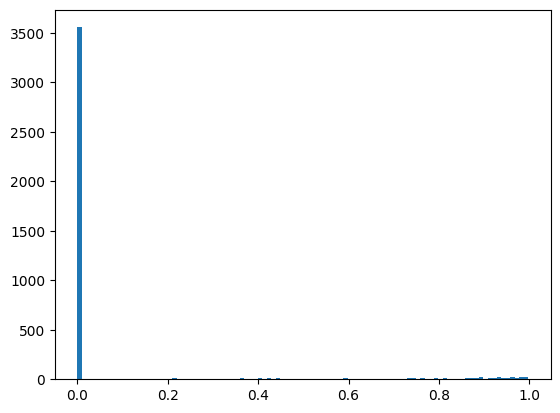

In [25]:
import matplotlib.pyplot as plt
plt.hist(x = bls, bins = 100)


